In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.getcwd()

'/content'

**Multi-type Aircraft Remote Sensing Images(MTARSI)** dataset contains **9385 images** of **20 aircraft types.** 

This dataset has,
- Varied backgrounds
- Different resolutions
- Distinct poses of aircrafts

### Observation:
- **Classes: type-12, 13,14,15,16,17,18,19,20,21** are **repeated classes**.So we have excluded these classes during our model building

- We find that few images for all classes are **synthetically generated by changing the backgrounds from background images.**

###Unzipping dataset

In [ ]:
print("Unzipping...")
!unzip -q drive/MyDrive/projectdatanew.zip
print("Done!!")

Unzipping...
Done!!


### Import Libraries

In [ ]:
!pip install shap
!pip install keras
!pip install Adam
!pip install adam

     |████████████████████████████████| 564 kB 5.4 MB/s 


In [ ]:
import os
import pandas as pd
import numpy as np
import math
import shap
import warnings
warnings.filterwarnings('ignore')

#Import Keras modules
import cv2
import keras
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, Input
from keras.layers import Conv2D, Activation, GlobalAveragePooling2D, MaxPool2D, Softmax
from tensorflow.keras.optimizers import Adam
from keras.regularizers import L2
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50

#Import visualization libraries
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns

#Import sklearn libraries
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

Creating,
- The **dictionary to exchange classes and labels**
- The function to get **images/labels from directories**

In [ ]:
label_to_class = {
    'B-1':0,
    'B-2':1,
    'B-52':2,
    'Boeing':3,
    'C-130':4,
    'C-135':5,
    'C-17':6,
    'C-5':7,
    'E-3':8,
    'F-22':9,
    'KC-10':10,
    'type-12(C-21)':11,
    'type-13(U-2)':12,
    'type-15(A-10)':13,
    'type-16(A-26)':14,
    'type-17(P-63)':15,
    'type-18(F-16)':16,
    'type-19(T-6)':17,
    'type-20(B-29)':18,
    'type-21(t-43)':19,
}
class_to_label = {v: k for k, v in label_to_class.items()}
n_classes = len(label_to_class)

In [ ]:
class_to_label

{0: 'B-1',
 1: 'B-2',
 2: 'B-52',
 3: 'Boeing',
 4: 'C-130',
 5: 'C-135',
 6: 'C-17',
 7: 'C-5',
 8: 'E-3',
 9: 'F-22',
 10: 'KC-10',
 11: 'type-12(C-21)',
 12: 'type-13(U-2)',
 13: 'type-15(A-10)',
 14: 'type-16(A-26)',
 15: 'type-17(P-63)',
 16: 'type-18(F-16)',
 17: 'type-19(T-6)',
 18: 'type-20(B-29)',
 19: 'type-21(t-43)'}

Creation of **dataframe with class names and labels**

In [ ]:
class_to_label_df = pd.DataFrame(class_to_label.items(), columns = ['class', 'className'])

In [ ]:
class_to_label_df.head()

,class,className
0,0,B-1
1,1,B-2
2,2,B-52
3,3,Boeing
4,4,C-130


### Finding the **resolution of the images** to **resize the dataset** accordingly

> Neural networks receive inputs of the same size, **all images** need to be **resized to a fixed size before inputting** them to the **CNN**.

> For this purpose, we selected a **resolution of 80 X 80 as an input for our model**, since there were images with varied resolutions, we picked the image with minimum resolution rather than padding the lower reoslution images.




In [ ]:
def get_min_resolution(dir_name='/content/airplane-dataset-trans', label_to_class=label_to_class):
    #Images = []
    #Classes = []
    img_size = []
    for label_name in os.listdir(dir_name):
        cls = label_to_class[label_name]
    
        for img_name in os.listdir('/'.join([dir_name, label_name])):
            im = load_img('/'.join([dir_name, label_name, img_name]))
            img_size.append((label_name+ '/' + img_name, im.size))
            
    return img_size

In [ ]:
img_size_list = get_min_resolution()

#Getting Minimum and maximum resolution of images
min([x[1] for x in img_size_list]), max([x[1] for x in img_size_list])

((80, 80), (588, 447))

Boeing/0-104.jpg


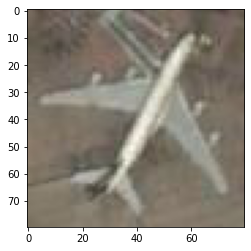

In [ ]:
#Getting the lowest resolution image
d_name = 'airplane-dataset-trans'

for x,y in img_size_list:
    if y == (80, 80):
        print(x)
        im = load_img('/'.join([d_name, x]))
        plt.imshow(im)

This **80 X 80 pixel image is sufficient to classify the aircraft visually by humans**, so we are **standardizing our dataset** to the same resolution.

## **Preprocessing Steps:**
- Resizing
- Normalization

## 1. Resizing

In [ ]:
W= 80 #Image Width
H = 80 #Image Height

def get_images(dir_name='airplane-dataset-trans', label_to_class=label_to_class):
    """read images / labels from directory"""
    
    Images = []
    Classes = []
    
    for label_name in os.listdir(dir_name):
        cls = label_to_class[label_name]
        
        for img_name in os.listdir('/'.join([dir_name, label_name])):
            img = load_img('/'.join([dir_name, label_name, img_name]), target_size=(W, H))
            img = img_to_array(img)
            
            Images.append(img)
            Classes.append(cls)
            
    Images = np.array(Images, dtype=np.float32)
    Classes = np.array(Classes, dtype=np.int)
    #Images, Classes = shuffle(Images, Classes, random_state=44)
    
    return Images, Classes

Getting images/labels

In [ ]:
Images, Classes = get_images()

Images.shape, Classes.shape

((9385, 80, 80, 3), (9385,))

### Number of images in each class

In [ ]:
unique, counts = np.unique(Classes, return_counts = True)
unique_count_list = list(zip(list(unique), list(counts)))

In [ ]:
img_count = pd.DataFrame(unique_count_list, columns = ['class', 'ImgCount'])
class_names_count_df = pd.merge(img_count, class_to_label_df, on='class', how='outer')

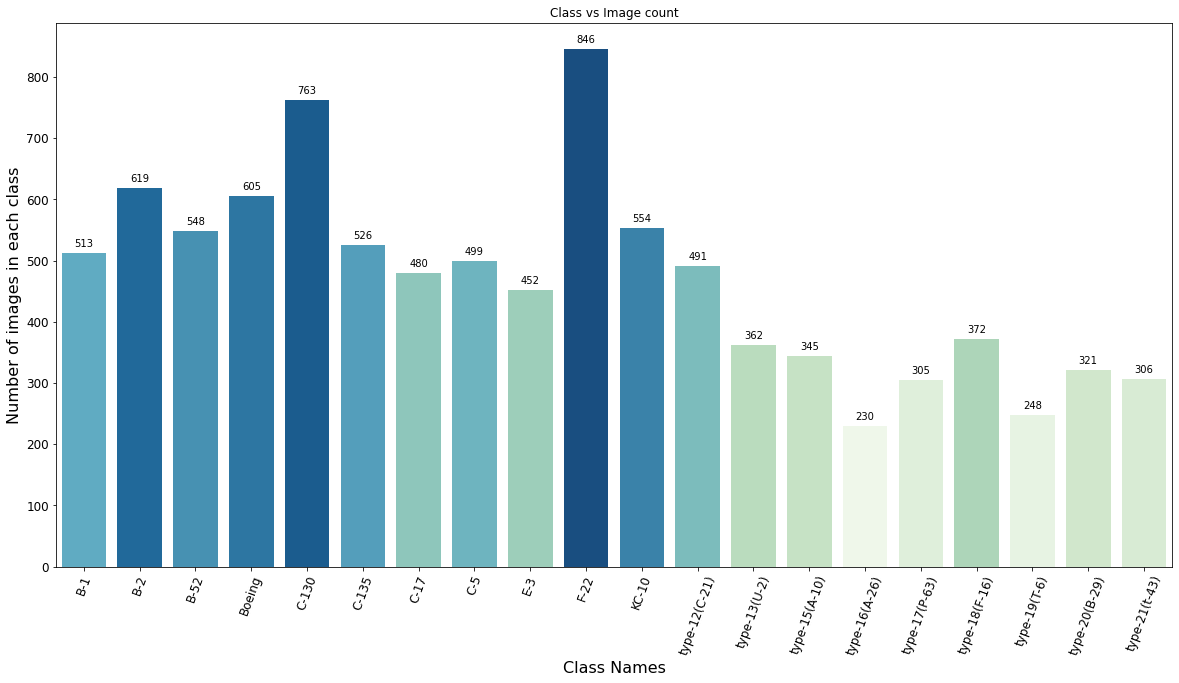

In [ ]:
#Seaborn Barplot and it's arguments

plt.figure(figsize=(20, 10))
pal = sns.color_palette("GnBu_r", len(class_names_count_df))
rank = class_names_count_df["ImgCount"].argsort().argsort() 

#Barplot with count
plots = sns.barplot(x="className", y="ImgCount",data=class_names_count_df, palette=np.array(pal[::-1])[rank])
for index, row in class_names_count_df.iterrows():
  plots.text(x=index, y=row.ImgCount+10, s=row.ImgCount, color = 'black', ha = 'center', fontsize=10)

# Iterrating over the bars one-by-one
plt.xticks(rotation=70, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Class Names", size=16)
  
# Setting the label for y-axis
plt.ylabel("Number of images in each class", size=16)
  
# Setting the title for the graph
plt.title("Class vs Image count")
  
# Fianlly showing the plot
plt.show()

## Hypothesis: 
- F-22, C-130, B-2, Boeing classes have more images than the rest, this can help in better prediction of these classes.
- type-16 (A-26), type-19(T-6) classes have lower number of images so may require augmentation or addition of more data to predict well.

Accordingly, we can design an autonomous or semi-autonomous aircraft tagging system. 

**Visualize images/lables for each class with**
- Class 
- Number of images in the class 
- Percentage of images in the class

In [ ]:
n_total_images = Images.shape[0]

for target_cls in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]:
    
    indices = np.where(Classes == target_cls)[0] # get target class indices on Images / Classes
    n_target_cls = indices.shape[0]
    label = class_to_label[target_cls]
    print(label, n_target_cls, round((n_target_cls/n_total_images) * 100, 2),'%')

    n_cols = 10 # # of sample plot
    fig, axs = plt.subplots(ncols=n_cols, figsize=(25, 3))

    for i in range(n_cols):

        axs[i].imshow(np.uint8(Images[indices[i]]))
        axs[i].axis('off')
        axs[i].set_title(label, fontsize =10)

    plt.show()

In [ ]:
Images.shape

(9385, 80, 80, 3)

## Split dataset into train, validation and test
Train: 7508
<br> Validation: 1501
<br> test : 376

Train Test Split ratio - 80: 20

In [ ]:
x_train, x_val_test, y_train, y_val_test = train_test_split(Images, Classes, train_size=0.8, test_size=0.2, stratify=Classes, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, train_size=0.8, test_size=0.2, stratify=y_val_test, random_state=42)

In [ ]:
#Shape of Train, Validation and Test
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((7508, 80, 80, 3),
 (7508,),
 (1501, 80, 80, 3),
 (1501,),
 (376, 80, 80, 3),
 (376,))

In [ ]:
## categorical to one-hot
y_train = to_categorical(y_train, n_classes)
y_val = to_categorical(y_val, n_classes)
y_test = to_categorical(y_test, n_classes)

y_train.shape ,y_val.shape, y_test.shape #(7508, 20)

((7508, 20), (1501, 20), (376, 20))

## 2. Normalising input images

Scales values of the **pixels in 0-1 range**

> Normalizing train, validation and test images **separately** so there is n**o data/info leak.**



In [ ]:
x_train /=255
x_val /=255
x_test /=255

## Model building 

## First Model

We started with an extremely simple model: (a) 4 convolutional blocks, each comprising one convolutional layer, one max pooling layer, and batch normalisation after the pooling layer, and (b) a fully-connected (FC) layer with 32 nodes. My key considerations were:



1.   Start Small. I don’t have a top-end GPU, so I had to be prudent with the size and complexity of the model. I also wanted the most parsimonious model possible.
2.   Opportunity to Experiment with Parameters. To figure out best practices in testing models, there is no shortcut — you need experience in tweaking your model, interpreting the results, and making further adjustments.

We used the other settings below. Generally, nothing changed throughout except the learning rate, which was specially-adjusted for each tested model.



*   Input size: 80x80 
*   For all convolutional layers: (1) a kernel size of 3x3, (2) ReLu activation, and (3) “same” padding
*  For all convolutional layers: (1) a kernel size of 3x3, (2) ReLu activation, and (3) “same” padding
*  For fully-connected layer(s): (1) dropout of 0.5 and (2) ReLu activation
*   For compiling the model: (1) categorical crossentropy for loss and (2) the Adam optimiser with a learning rate of 0.0001 (found after some experimentation)
*   For fitting: (1) a batch size of 16 and (2) early stopping with a patience of 50 epochs.









In [ ]:

# Initialise model
model = Sequential()

# Block 1
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01), input_shape=(80, 80, 3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

# Block 2
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

# Block 3
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

# Block 4
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.0001)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

# Dense
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

# Softmax
model.add(Dense(20, activation='softmax'))

# Compile
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 40, 40, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 64)       0         
 2D)                                                             
                                                        

## Model Training

1. **Loss funtion:** 'Categorical crossentropy' . Used in Multi-class classification tasks
2. **Optimizer:** 'Adam' derived from Adaptive moment estimation
3. **Metrics:** Accuracy, Precision, Recall
4. **LR scheduler** used reduces learning rate by a factor of 10 (lr/10) for every epoch after 10th epoch.
5. **Early stopping**: When the model performance isn't improving for two consecutive epochs, training is stopped and mode is saved.

##Hyperparamters used:
**learning rate** (lr = 0.0001)
<br>**batch size**  (batch size =16)
<br>**number of epochs** (epochs = 25)

In [ ]:
# Compile
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

In [ ]:
def scheduler(epoch, lr):
   if epoch < 10:
     return lr
   else:
     return lr * math.exp(-0.1)

In [ ]:
working_dir = "drive/MyDrive/MTARSI/SavedModels/"
file_name = 'model.{epoch:02d}-{accuracy:.2f}.h5'

my_callbacks = [
    EarlyStopping(monitor = 'loss', patience=2),
    LearningRateScheduler(scheduler),
    ModelCheckpoint(filepath= os.path.join(working_dir, 'firstModel', file_name), save_best_only=True), 
    TensorBoard(log_dir='./logs'),
]

In [ ]:
print("Fit model on training data")
history = model.fit(x_train, y_train, epochs=25, batch_size=16, callbacks=my_callbacks, validation_data=(x_val, y_val))

Fit model on training data
Epoch 1/25
470/470 [==============================] - 20s 21ms/step - loss: 4.1129 - accuracy: 0.0912 - val_loss: 3.9121 - val_accuracy: 0.1186 - lr: 1.0000e-04
Epoch 2/25
470/470 [==============================] - 8s 16ms/step - loss: 3.7147 - accuracy: 0.1739 - val_loss: 3.4215 - val_accuracy: 0.3051 - lr: 1.0000e-04
Epoch 3/25
470/470 [==============================] - 8s 16ms/step - loss: 3.3977 - accuracy: 0.2472 - val_loss: 3.0642 - val_accuracy: 0.3811 - lr: 1.0000e-04
Epoch 4/25
470/470 [==============================] - 7s 15ms/step - loss: 3.1302 - accuracy: 0.3197 - val_loss: 2.7921 - val_accuracy: 0.4890 - lr: 1.0000e-04
Epoch 5/25
470/470 [==============================] - 7s 16ms/step - loss: 2.9102 - accuracy: 0.3640 - val_loss: 2.5701 - val_accuracy: 0.5496 - lr: 1.0000e-04
Epoch 6/25
470/470 [==============================] - 7s 15ms/step - loss: 2.6749 - accuracy: 0.4281 - val_loss: 2.4034 - val_accuracy: 0.5836 - lr: 1.0000e-04
Epoch 7/25
4

### Plotting Model metrics

[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epoch')]

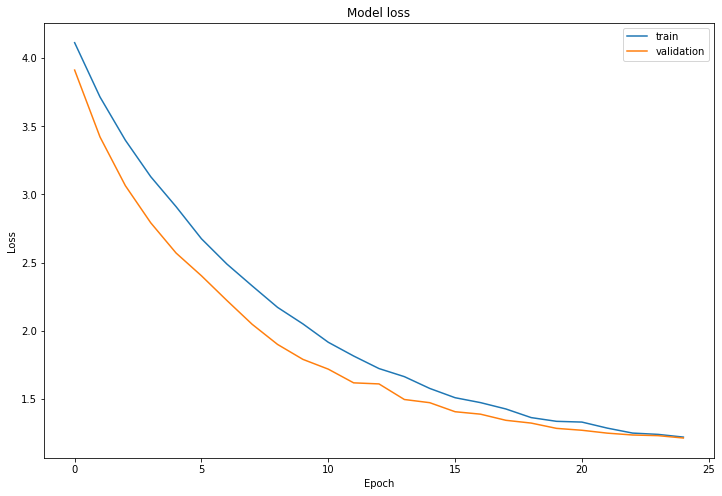

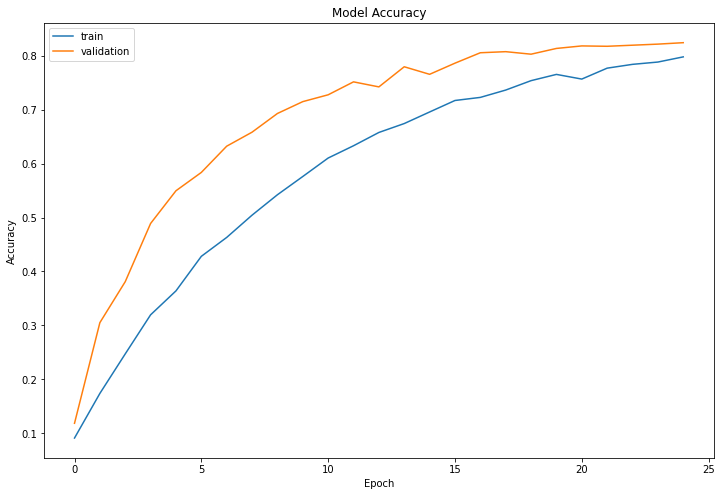

In [ ]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

### Save the model as .h5 file

In [ ]:
#Save model
model.save('drive/MyDrive/MTARSI/SavedModels/my_model_submission.h5')
print("model saved!!!")

model saved!!!


### Load the saved .h5 model file

In [ ]:
#Load model
print("Model Loading...")
model = load_model('drive/MyDrive/MTARSI/SavedModels/my_model_submission.h5')
model.summary()

Model Loading...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 40, 40, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 64)       0         
 2D)                                                             
                                       

## Evaluating model performance on test data

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=16)
print("test loss, test acc:", results)

Evaluate on test data
24/24 [==============================] - 1s 11ms/step - loss: 1.1900 - accuracy: 0.8378
test loss, test acc: [1.1899683475494385, 0.8377659320831299]


In [ ]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for all samples")
predictions = model.predict(x_test)
print("predictions shape:", predictions.shape)

Generate predictions for all samples
predictions shape: (376, 20)


In [ ]:
x_test.shape, y_test.shape, predictions.shape

((376, 80, 80, 3), (376, 20), (376, 20))

## Misclassified Images

In [ ]:
class_pred = []
pred_label = []
act_label= []
misclassified_img = []
for i in range(predictions.shape[0]):
  class_pred.append(predictions[i].argmax())
  pred_label.append(class_to_label[class_pred[i]])
  act_label.append(class_to_label[y_test[i].argmax()])
  if pred_label[i] != act_label[i]:
    misclassified_img.append(i)

In [ ]:
print("Number of misclassified images",len(misclassified_img))

Number of misclassified images 61


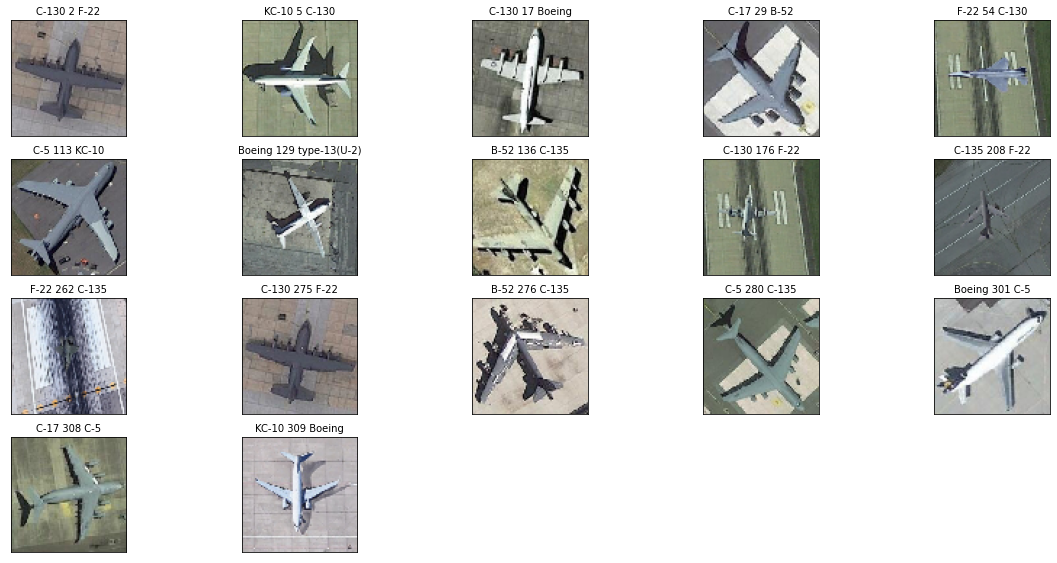

In [ ]:
fig = plt.figure(figsize=(20, 20))

for i in range(len(misclassified_img)):
  ax = fig.add_subplot(8, 5, i+1,xticks=[], yticks=[])
  image = x_test[misclassified_img[i]]
  label_true = act_label[misclassified_img[i]]
  label_guess = pred_label[misclassified_img[i]]
  ax.imshow(image)
  ax.set_title("{} {:0.0f} {}".format(label_true, misclassified_img[i], label_guess), fontsize=10)

## Commonly misclassified classes:
- **C-135** (as B-52, Boeing) - classes are visually similar (4 engine aircrafts) - Manual tagging required. 
- **C-135, C130, C-5, C-17** (as **C-types, Boeing and Viceversa**)- All with **4 engines or long fuselage**
- **F-22** (similar to F-16), **(as C-types)**  - **Overfitting**
- **KC-10** (as C-type) - Need more images to train on
- **type-12(C-21)** (as other C-types) - Fuselage length and engine mounting differs




## Confusion Matrix
To visualize the performance of the model on the **predicted classes vs Ground Truth**. 

We can see, the **commonly confused classes are C-types aircrafts with KC-10, F-22 and Boeing**

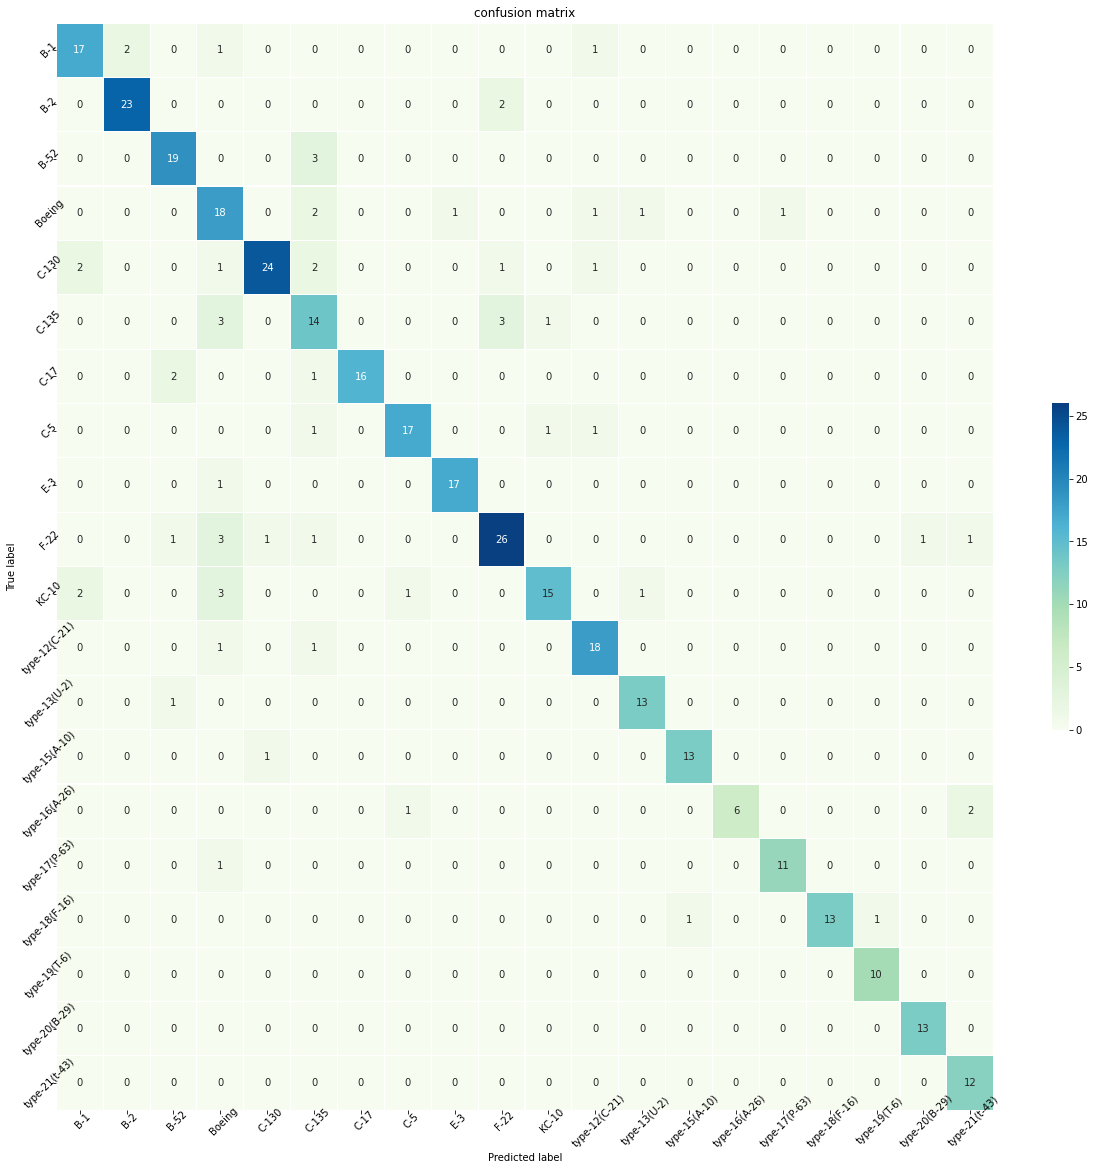

In [ ]:
## plot confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis =1), class_pred)

fig, ax = plt.subplots(figsize=(21, 20))

sns.heatmap(cm, annot=True, fmt='d', cmap='GnBu', cbar_kws={'shrink': .3}, linewidths=.1, ax=ax)

ax.set(
    xticklabels=list(label_to_class.keys()),
    yticklabels=list(label_to_class.keys()),
    title='confusion matrix',
    ylabel='True label',
    xlabel='Predicted label'
)
params = dict(rotation=45, ha='center', rotation_mode='anchor')
plt.setp(ax.get_yticklabels(), **params)
plt.setp(ax.get_xticklabels(), **params)
plt.show()

In [ ]:
#Class wise accuracy
matrix = confusion_matrix(np.argmax(y_test, axis =1), class_pred)
class_acc = ((matrix.diagonal()/matrix.sum(axis=1)) *100)
print((matrix.diagonal()/matrix.sum(axis=1)) *100)

[ 80.95238095  92.          86.36363636  75.          77.41935484
  66.66666667  84.21052632  85.          94.44444444  76.47058824
  68.18181818  90.          92.85714286  92.85714286  66.66666667
  91.66666667  86.66666667 100.         100.         100.        ]


In [ ]:
class_names_count_df['Class_Accuracy'] = class_acc
class_names_count_df = class_names_count_df.round({"Class_Accuracy":2})
class_names_count_df.head()

,class,ImgCount,className,Class_Accuracy
0,0,513,B-1,80.95
1,1,619,B-2,92.00
2,2,548,B-52,86.36
3,3,605,Boeing,75.00
4,4,763,C-130,77.42


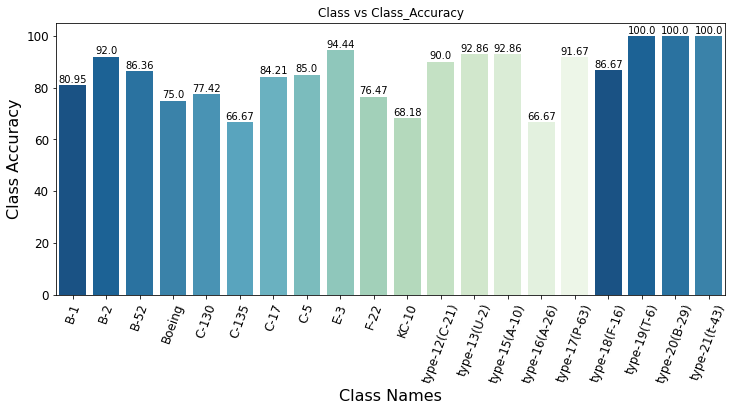

In [ ]:
#Seaborn Barplot and it's arguments

plt.figure(figsize=(12, 5))
pal = sns.color_palette("GnBu_r", n_colors=len(set(class_names_count_df["Class_Accuracy"])))

#Barplot with count
plots = sns.barplot(x="className", y="Class_Accuracy",data=class_names_count_df, palette=pal)
for index, row in class_names_count_df.iterrows():
  plots.text(x=index, y=row.Class_Accuracy+1, s=row.Class_Accuracy, color = 'black', ha = 'center', fontsize=10)

# Iterrating over the bars one-by-one
plt.xticks(rotation=70, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Class Names", size=16)
  
# Setting the label for y-axis
plt.ylabel("Class Accuracy", size=16)
  
# Setting the title for the graph
plt.title("Class vs Class_Accuracy")
  
# Fianlly showing the plot
plt.show()

## The final model 
It was much more complex with 12 million parameters across 13 weight layers. See below for the code to build the model, the model summary and a diagram of the architecture:


In [ ]:

# Initialise model
model = Sequential()

# Block 1
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01), input_shape=(80, 80, 3)))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

# Block 2
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

# Block 3
model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

# Block 4
model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

# Dense
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# Softmax
model.add(Dense(20, activation='softmax'))

# Compile
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.00004),
    metrics=['accuracy']
)

In [ ]:
def scheduler(epoch, lr):
   if epoch < 10:
     return lr
   else:
     return lr * math.exp(-0.1)

In [ ]:
print("Fit model on training data")
history = model.fit(x_train, y_train, epochs=25, batch_size=16, callbacks=my_callbacks, validation_data=(x_val, y_val))

Fit model on training data
Epoch 1/25
470/470 [==============================] - 62s 126ms/step - loss: 27.2789 - accuracy: 0.2460 - val_loss: 27.4801 - val_accuracy: 0.1186 - lr: 4.0000e-05
Epoch 2/25
470/470 [==============================] - 57s 122ms/step - loss: 25.2613 - accuracy: 0.4706 - val_loss: 24.2848 - val_accuracy: 0.5856 - lr: 4.0000e-05
Epoch 3/25
470/470 [==============================] - 57s 122ms/step - loss: 23.5036 - accuracy: 0.6288 - val_loss: 22.6813 - val_accuracy: 0.6755 - lr: 4.0000e-05
Epoch 4/25
470/470 [==============================] - 55s 118ms/step - loss: 21.8603 - accuracy: 0.7445 - val_loss: 21.2836 - val_accuracy: 0.7355 - lr: 4.0000e-05
Epoch 5/25
470/470 [==============================] - 56s 118ms/step - loss: 20.3587 - accuracy: 0.8247 - val_loss: 19.8424 - val_accuracy: 0.8001 - lr: 4.0000e-05
Epoch 6/25
470/470 [==============================] - 56s 119ms/step - loss: 18.9280 - accuracy: 0.8901 - val_loss: 18.5396 - val_accuracy: 0.8235 - lr: 

[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epoch')]

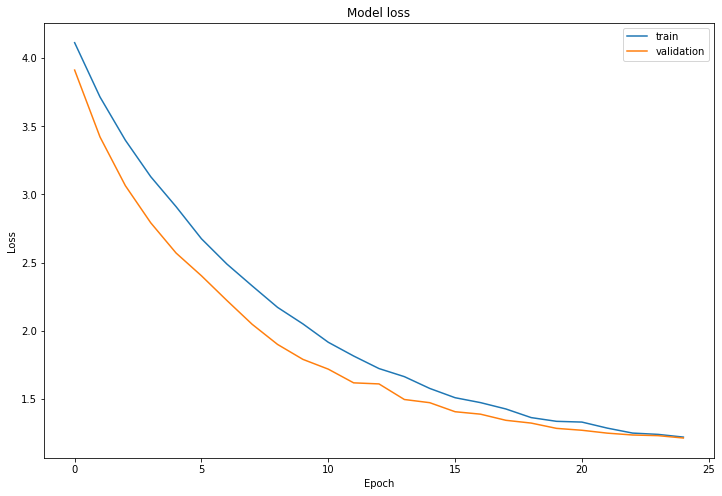

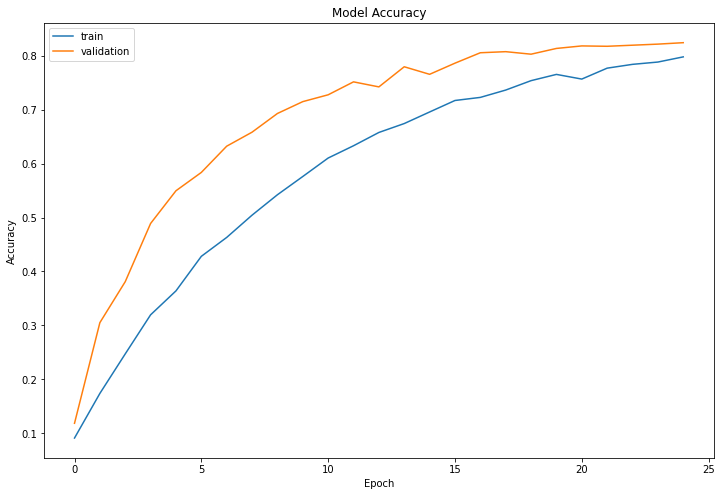

In [ ]:
mdf_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

In [ ]:
#Save model
model.save('drive/MyDrive/MTARSI/SavedModels/my_model_submission.h5')
print("model saved!!!")

model saved!!!


In [ ]:
#Load model
print("Model Loading...")
model = load_model('drive/MyDrive/MTARSI/SavedModels/my_model_submission.h5')
model.summary()

Model Loading...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 80, 80, 64)        1792      
                                                                 
 conv2d_5 (Conv2D)           (None, 80, 80, 64)        36928     
                                                                 
 conv2d_6 (Conv2D)           (None, 80, 80, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 40, 40, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 40, 40, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 4

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=16)
print("test loss, test acc:", results)

Evaluate on test data
24/24 [==============================] - 2s 60ms/step - loss: 4.9126 - accuracy: 0.9548
test loss, test acc: [4.912646770477295, 0.9547872543334961]


In [ ]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for all samples")
predictions = model.predict(x_test)
print("predictions shape:", predictions.shape)

Generate predictions for all samples
predictions shape: (376, 20)


In [ ]:
class_pred = []
pred_label = []
act_label= []
misclassified_img = []
for i in range(predictions.shape[0]):
  class_pred.append(predictions[i].argmax())
  pred_label.append(class_to_label[class_pred[i]])
  act_label.append(class_to_label[y_test[i].argmax()])
  if pred_label[i] != act_label[i]:
    misclassified_img.append(i)

In [ ]:
print("Number of misclassified images",len(misclassified_img))

Number of misclassified images 17


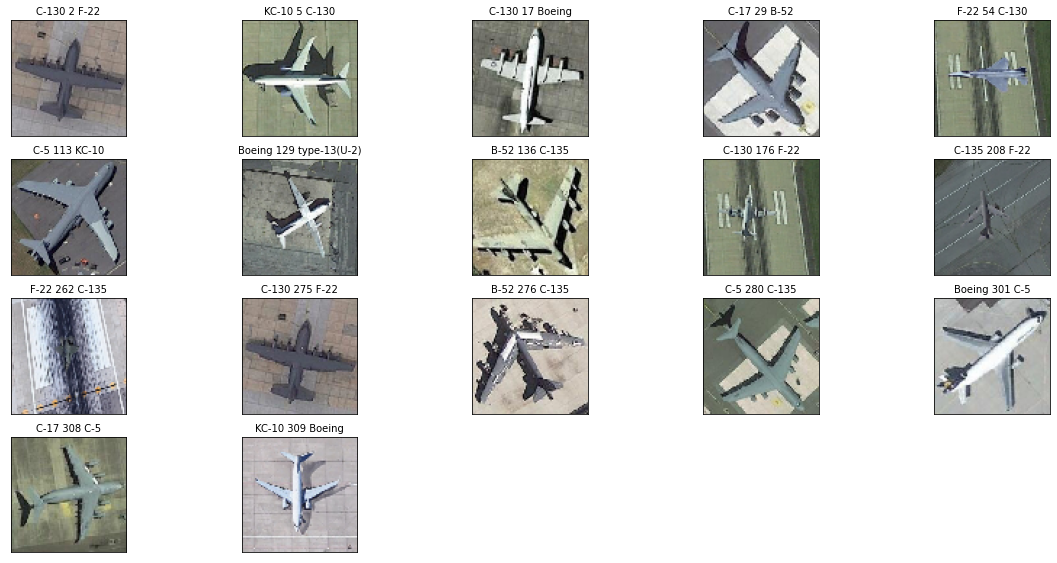

In [ ]:
fig = plt.figure(figsize=(20, 20))

for i in range(len(misclassified_img)):
  ax = fig.add_subplot(8, 5, i+1,xticks=[], yticks=[])
  image = x_test[misclassified_img[i]]
  label_true = act_label[misclassified_img[i]]
  label_guess = pred_label[misclassified_img[i]]
  ax.imshow(image)
  ax.set_title("{} {:0.0f} {}".format(label_true, misclassified_img[i], label_guess), fontsize=10)


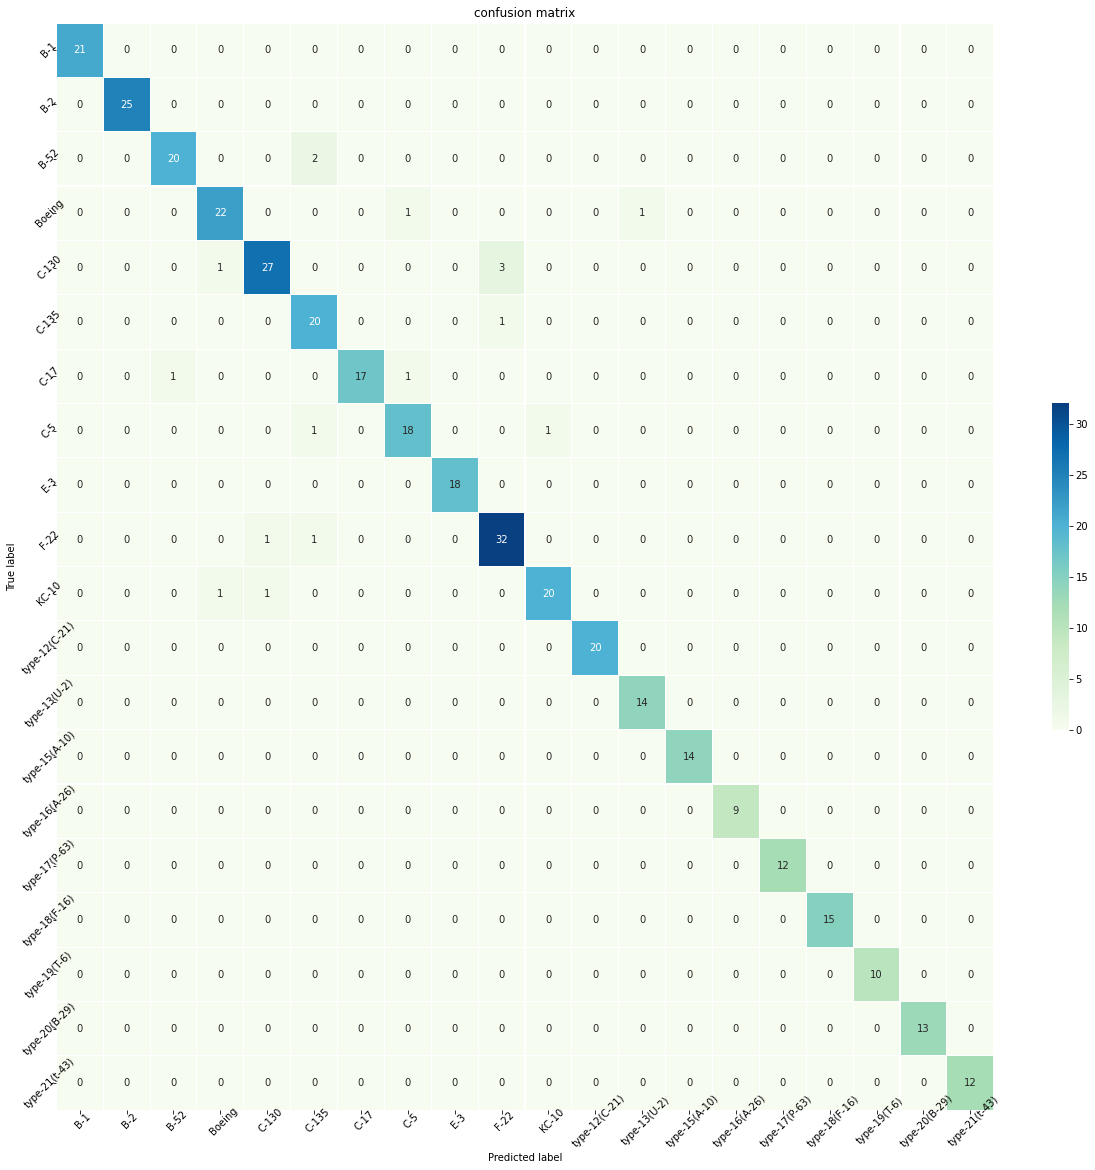

In [ ]:
## plot confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis =1), class_pred)

fig, ax = plt.subplots(figsize=(21, 20))

sns.heatmap(cm, annot=True, fmt='d', cmap='GnBu', cbar_kws={'shrink': .3}, linewidths=.1, ax=ax)

ax.set(
    xticklabels=list(label_to_class.keys()),
    yticklabels=list(label_to_class.keys()),
    title='confusion matrix',
    ylabel='True label',
    xlabel='Predicted label'
)
params = dict(rotation=45, ha='center', rotation_mode='anchor')
plt.setp(ax.get_yticklabels(), **params)
plt.setp(ax.get_xticklabels(), **params)
plt.show()

In [ ]:
#Class wise accuracy
matrix = confusion_matrix(np.argmax(y_test, axis =1), class_pred)
class_acc = ((matrix.diagonal()/matrix.sum(axis=1)) *100)
print((matrix.diagonal()/matrix.sum(axis=1)) *100)

[100.         100.          90.90909091  91.66666667  87.09677419
  95.23809524  89.47368421  90.         100.          94.11764706
  90.90909091 100.         100.         100.         100.
 100.         100.         100.         100.         100.        ]


In [ ]:
class_names_count_df['Class_Accuracy'] = class_acc
class_names_count_df = class_names_count_df.round({"Class_Accuracy":2})
class_names_count_df.head()

,class,ImgCount,className,Class_Accuracy
0,0,513,B-1,100.00
1,1,619,B-2,100.00
2,2,548,B-52,90.91
3,3,605,Boeing,91.67
4,4,763,C-130,87.10


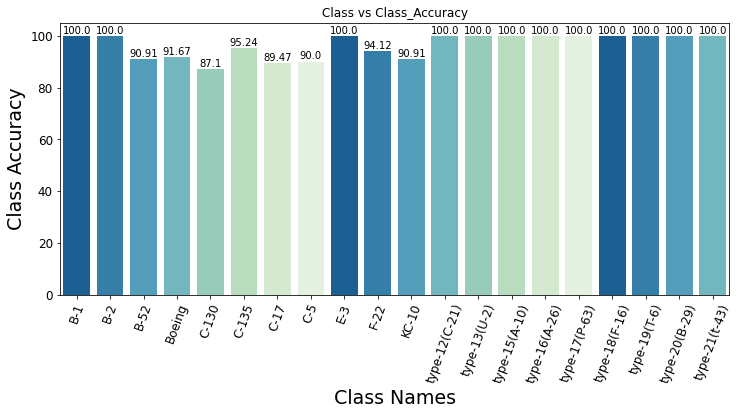

In [ ]:
#Seaborn Barplot and it's arguments

plt.figure(figsize=(12, 5))
pal = sns.color_palette("GnBu_r", n_colors=len(set(class_names_count_df["Class_Accuracy"])))

#Barplot with count
plots = sns.barplot(x="className", y="Class_Accuracy",data=class_names_count_df, palette=pal)
for index, row in class_names_count_df.iterrows():
  plots.text(x=index, y=row.Class_Accuracy+1, s=row.Class_Accuracy, color = 'black', ha = 'center', fontsize=10)

# Iterrating over the bars one-by-one
plt.xticks(rotation=70, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Class Names", size=19)
  
# Setting the label for y-axis
plt.ylabel("Class Accuracy", size=19)
  
# Setting the title for the graph
plt.title("Class vs Class_Accuracy")
  
# Fianlly showing the plot
plt.show()

In [ ]:
results = model.evaluate(x_test, y_test, batch_size=19)
print('Test Accuracy: {:.2f}%'.format(results[1]*100))

20/20 [==============================] - 3s 95ms/step - loss: 4.9126 - accuracy: 0.9548
Test Accuracy: 95.48%


In [ ]:
results = model.evaluate(x_test, y_test, batch_size=19)
print('Test Accuracy: {:.2f}%'.format(results[1]*100))
results = model.evaluate(x_train, y_train, batch_size=19)
print('Train Accuracy: {:.2f}%'.format(results[1]*100))

20/20 [==============================] - 1s 51ms/step - loss: 4.9126 - accuracy: 0.9548
Test Accuracy: 95.48%
396/396 [==============================] - 21s 53ms/step - loss: 4.7554 - accuracy: 0.9995
Train Accuracy: 99.95%


In [ ]:
y_pred =model.predict(x_test)

In [ ]:
y_classes = [np.argmax(element) for element in y_pred]

In [ ]:
y_classes[0:5]

[13, 11, 9, 18, 1]

In [ ]:
#Load model
from keras.models import load_model
print("Model Loading...")
model = load_model('drive/MyDrive/MTARSI/SavedModels/my_model_submission.h5')
model.summary()

Model Loading...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 80, 80, 64)        1792      
                                                                 
 conv2d_5 (Conv2D)           (None, 80, 80, 64)        36928     
                                                                 
 conv2d_6 (Conv2D)           (None, 80, 80, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 40, 40, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 40, 40, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 4

In [ ]:
my_dict ={ 'B-1':0,
    'B-2':1,
    'B-52':2,
    'Boeing':3,
    'C-130':4,
    'C-135':5,
    'C-17':6,
    'C-5':7,
    'E-3':8,
    'F-22':9,
    'KC-10':10,
    'type-12(C-21)':11,
    'type-13(U-2)':12,
    'type-15(A-10)':13,
    'type-16(A-26)':14,
    'type-17(P-63)':15,
    'type-18(F-16)':16,
    'type-19(T-6)':17,
    'type-20(B-29)':18,
    'type-21(t-43)':19
}
key_list = list(my_dict.keys())
val_list = list(my_dict.values())

In [ ]:
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())
upload_files()

Saving 10-3.jpg to 10-3.jpg


['10-3.jpg']

F-22


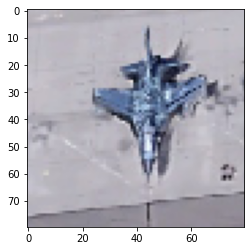

In [ ]:
from numpy.core.fromnumeric import argmax
from tensorflow.keras.preprocessing import image
import matplotlib.pylab as plt
img_width = 80
img_height = 80

img = image.load_img('/content/10-3.jpg', target_size=(img_width, img_height, 3))
plt.imshow(img)
img = image.img_to_array(img)
img = img/255.0

img = img.reshape(1, img_width, img_height, 3)

y_prob = model.predict(img)
out = argmax(y_prob)
print(list(my_dict.keys())[list(my_dict.values()).index(out)])